In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from wget import download
from os import path

# leemos los datos del archivo
dataset_compras = pd.read_csv("online_shoppers_intention.csv")
dataset_compras.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [16]:
# Eliminar duplicados exactos (mantiene la primera ocurrencia)
df = dataset_compras.drop_duplicates(keep='first')

print(f"📊 ANTES: {len(dataset_compras)} registros")
print(f"📊 DESPUÉS: {len(df)} registros")
print(f"🗑️  Se eliminaron {len(dataset_compras) - len(df)} registros duplicados")

📊 ANTES: 12330 registros
📊 DESPUÉS: 12205 registros
🗑️  Se eliminaron 125 registros duplicados


In [17]:

def corregir_inconsistencias_knn(df):
    """
    Corrige inconsistencias usando K-Nearest Neighbors
    """
    df_corregido = df.copy()
    
    # 1. INCONSISTENCIAS GRAVES: Páginas=0 pero Duración>0
    # Para estas, la duración DEBE ser 0
    mascara_admin = (df['Administrative'] == 0) & (df['Administrative_Duration'] > 0)
    mascara_info = (df['Informational'] == 0) & (df['Informational_Duration'] > 0)
    mascara_prod = (df['ProductRelated'] == 0) & (df['ProductRelated_Duration'] > 0)
    
    df_corregido.loc[mascara_admin, 'Administrative_Duration'] = 0
    df_corregido.loc[mascara_info, 'Informational_Duration'] = 0
    df_corregido.loc[mascara_prod, 'ProductRelated_Duration'] = 0
    
    print(f"✅ Corregidas {mascara_admin.sum()} inconsistencias en Administrative")
    print(f"✅ Corregidas {mascara_info.sum()} inconsistencias en Informational")
    print(f"✅ Corregidas {mascara_prod.sum()} inconsistencias en ProductRelated")
    
    # 2. INCONSISTENCIAS LEVES: Páginas>0 pero Duración=0
    # Para estas, usaremos K-NN para imputar valores razonables
    features_para_knn = [
        'Administrative', 'Administrative_Duration',
        'Informational', 'Informational_Duration', 
        'ProductRelated', 'ProductRelated_Duration',
        'BounceRates', 'ExitRates', 'PageValues'
    ]
    
    # Preparar datos para K-NN
    df_knn = df_corregido[features_para_knn].copy()
    
    # Aplicar K-NN para cada tipo de inconsistencia leve
    for page_type in ['Administrative', 'Informational', 'ProductRelated']:
        duration_col = f'{page_type}_Duration'
        
        # Identificar inconsistencias leves
        mascara_leve = (df_corregido[page_type] > 0) & (df_corregido[duration_col] == 0)
        
        if mascara_leve.sum() > 0:
            print(f"\n🔧 Aplicando K-NN a {mascara_leve.sum()} registros de {page_type}>0 y Duration=0")
            
            # Para estos registros, usar K-NN para predecir duración
            # (implementación simplificada - podrías usar sklearn KNNImputer)
            duracion_promedio = df_corregido[
                (df_corregido[page_type] > 0) & (df_corregido[duration_col] > 0)
            ][duration_col].mean()
            
            # Asignar duración promedio basada en número de páginas similares
            df_corregido.loc[mascara_leve, duration_col] = duracion_promedio * 0.5  # Conservador
    
    return df_corregido

# Aplicar corrección
df = corregir_inconsistencias_knn(df)

✅ Corregidas 0 inconsistencias en Administrative
✅ Corregidas 0 inconsistencias en Informational
✅ Corregidas 0 inconsistencias en ProductRelated

🔧 Aplicando K-NN a 135 registros de Administrative>0 y Duration=0

🔧 Aplicando K-NN a 226 registros de Informational>0 y Duration=0

🔧 Aplicando K-NN a 592 registros de ProductRelated>0 y Duration=0


In [18]:
# Convertir booleanos a binarios (True=1, False=0)
df['Weekend'] = df['Weekend'].astype(int)
df['Revenue'] = df['Revenue'].astype(int)

print("✅ Columnas convertidas a binarias:")
print(f"Weekend: {df['Weekend'].unique()}")
print(f"Revenue: {df['Revenue'].unique()}")

✅ Columnas convertidas a binarias:
Weekend: [0 1]
Revenue: [0 1]


In [19]:
# One-Hot Encoding con get_dummies
visitor_dummies = pd.get_dummies(df['VisitorType'], prefix='Visitor')

# Concatenar con el dataset original
df = pd.concat([df, visitor_dummies], axis=1)

# Eliminar la columna original (opcional)
df = df.drop('VisitorType', axis=1)


df["Visitor_New_Visitor"] = df['Visitor_New_Visitor'].astype(int)
df["Visitor_Other"] = df['Visitor_Other'].astype(int)
df["Visitor_Returning_Visitor"] = df['Visitor_Returning_Visitor'].astype(int)

print("✅ One-Hot Encoding completado:")
print(f"Columnas creadas: {list(visitor_dummies.columns)}")



✅ One-Hot Encoding completado:
Columnas creadas: ['Visitor_New_Visitor', 'Visitor_Other', 'Visitor_Returning_Visitor']


In [20]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,Weekend,Revenue,Visitor_New_Visitor,Visitor_Other,Visitor_Returning_Visitor
0,0,0.0,0,0.0,1,636.337836,0.20,0.20,0.0,0.0,Feb,1,1,1,1,0,0,0,0,1
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,0,0,0,0,1
2,0,0.0,0,0.0,1,636.337836,0.20,0.20,0.0,0.0,Feb,4,1,9,3,0,0,0,0,1
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,0,0,0,0,1
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,1,0,0,0,1


#### PLANTEO DE HIPOTESIS : UNIVARIADAS

Hipótesis 1 : La mayoria de las compras se realizan en el ultimo trimestre del ano.
(preguntar : en Noviembre se celebra el dia de accion de gracias en EEUU, deberiamos mencionar las causas que generan nuestra validacion de hipotesis?)

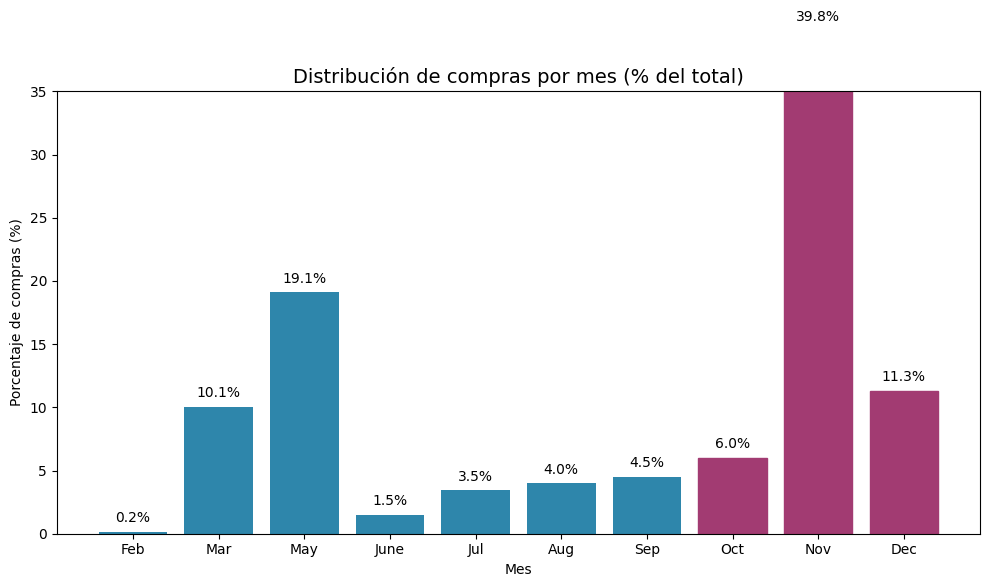

Total de compras registradas: 1908
Porcentaje de compras en Oct–Dic: 57.2%


In [ ]:
# 1. Filtrar solo las sesiones con Revenue = TRUE
df_compras = df[df['Revenue'] == True]

# 2. Contar compras por mes
compras_por_mes = df_compras['Month'].value_counts().reindex(
    ['Feb', 'Mar', 'May', 'June', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
    fill_value=0
)

# 3. Calcular porcentaje del total
total_compras = compras_por_mes.sum()
porcentaje_por_mes = (compras_por_mes / total_compras) * 100

# 4. Calcular porcentaje para el trimestre Oct–Dic
trimestre_oct_dic = porcentaje_por_mes[['Oct', 'Nov', 'Dec']].sum()

# 5. Visualización
plt.figure(figsize=(10, 6))
bars = plt.bar(porcentaje_por_mes.index, porcentaje_por_mes.values, color='#2E86AB')
plt.title('Distribución de compras por mes (% del total)', fontsize=14)
plt.ylabel('Porcentaje de compras (%)')
plt.xlabel('Mes')
plt.ylim(0, 35)

# Añadir etiquetas de valor encima de cada barra
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{height:.1f}%', ha='center', va='bottom', fontsize=10)

# Resaltar Oct–Dic
for i, mes in enumerate(porcentaje_por_mes.index):
    if mes in ['Oct', 'Nov', 'Dec']:
        bars[i].set_color('#A23B72')

plt.tight_layout()
plt.show()

# 6. Mostrar conclusión numérica
print(f"Total de compras registradas: {total_compras}")
print(f"Porcentaje de compras en Oct–Dic: {trimestre_oct_dic:.1f}%")

In [34]:
df_revenue = df[df['Revenue'] == True]
print(f"Total de registros con compras (Revenue=True): {len(df_revenue)}")
print("\n")

# 2. Conteo de compras (Revenue=True) por mes
# (Usamos value_counts() como en la Práctica 4)
compras_por_mes = df_revenue['Month'].value_counts()

print("--- Compras (Revenue=True) por Mes (Ordenado por cantidad) ---")
print(compras_por_mes)
print("\n")

# 3. Comprobación de Hipótesis:
# (Usamos groupby.mean() como se ve en la Práctica 5)
# Calculamos el promedio de SpecialDay POR MES, solo para las compras con revenue

print("--- Comprobación de Hipótesis (SpecialDay) ---")
print("Analizando el valor PROMEDIO de 'SpecialDay' para las compras de cada mes...")

print("\n")

analisis_specialday = df_revenue.groupby('Month')['SpecialDay'].mean()

# Combinamos los conteos de compras con el promedio de SpecialDay
# (Usamos pd.concat, visto en Práctica 4)
df_hipotesis = pd.concat([
    compras_por_mes.rename('Cantidad_Compras'),
    analisis_specialday.rename('Promedio_SpecialDay')
], axis=1)

# Ordenamos por la cantidad de compras para ver los meses "top"
df_hipotesis = df_hipotesis.sort_values(by='Cantidad_Compras', ascending=False)

print("--- Tabla de Hipótesis: Meses con más compras vs. Promedio de Día Festivo ---")
print(df_hipotesis)

Total de registros con compras (Revenue=True): 1908


--- Compras (Revenue=True) por Mes (Ordenado por cantidad) ---
Month
Nov     760
May     365
Dec     216
Mar     192
Oct     115
Sep      86
Aug      76
Jul      66
June     29
Feb       3
Name: count, dtype: int64


--- Comprobación de Hipótesis (SpecialDay) ---
Analizando el valor PROMEDIO de 'SpecialDay' para las compras de cada mes...


--- Tabla de Hipótesis: Meses con más compras vs. Promedio de Día Festivo ---
       Cantidad_Compras  Promedio_SpecialDay
Month                                       
Nov                 760             0.000000
May                 365             0.116164
Dec                 216             0.000000
Mar                 192             0.000000
Oct                 115             0.000000
Sep                  86             0.000000
Aug                  76             0.000000
Jul                  66             0.000000
June                 29             0.000000
Feb                   3       

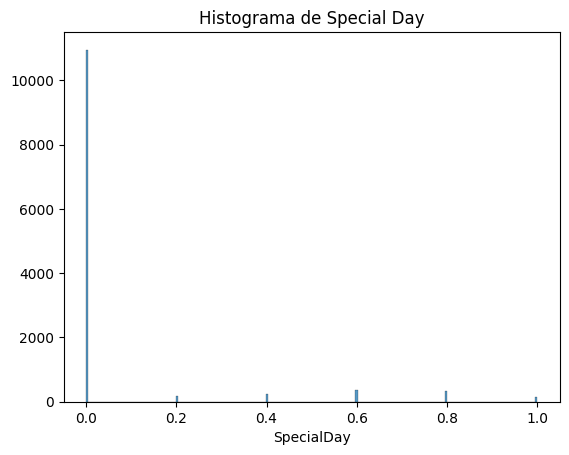

In [36]:
sns.histplot(x=df["SpecialDay"])
plt.title("Histograma de Special Day")
plt.ylabel("")
plt.show()